# Imports and files

In [10]:
from pathlib import Path

import anndata as ad
import numpy as np
import pandas as pd
import polars as pl
import scanpy as sc
from matplotlib_scalebar.scalebar import ScaleBar
from utils import celltype_signatures

from sainsc import GridCounts, LazyKDE

In [2]:
data_path = Path("data")
analysis_path = Path("Xenium")

xenium_file = data_path / "Xenium" / "transcripts.csv.gz"

single_cell_file = (
    data_path
    / "xenium-salas"
    / "adata_multisection_nuclei_3rep_withHM_withclusters.h5ad"
)
celltype_color_file = data_path / "xenium-salas" / "celltype_colors.json"
signature_file_abc_atlas = "abc_brain_signatures_pvt.tsv"
signature_file_out = analysis_path / "Xenium_signatures.tsv"

In [3]:
analysis_path.mkdir(exist_ok=True, parents=True)

In [4]:
# Palettes (for figures only)

kde_cmap = "magma"
assignment_score_cmap = "viridis"

# Analysis

## Signatures

In [5]:
xenium_segmentation = ad.read_h5ad(single_cell_file)
xenium_segmentation.obs_names_make_unique()

/dh-projects/ag-ishaque/analysis/muellni/envs/sainsc/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [5]:
signatures = celltype_signatures(xenium_segmentation, celltype_col="Class")
signatures = signatures.reindex(sorted(signatures.columns), axis=1)

signatures.to_csv(signature_file_out, sep="\t")

In [6]:
del xenium_segmentation

## Load Xenium data

In [7]:
n_threads = 16

In [8]:
transcripts = (
    pl.read_csv(
        xenium_file,
        columns=["feature_name", "x_location", "y_location"],
        dtypes={"feature_name": pl.Categorical},
        n_threads=n_threads,
    )
    .rename({"feature_name": "gene", "x_location": "x", "y_location": "y"})
    .filter(~pl.col("gene").cast(pl.Utf8).str.contains("(BLANK|NegControl)"))
)

xenium = LazyKDE(
    GridCounts.from_dataframe(
        transcripts, binsize=0.5, resolution=1_000, n_threads=n_threads
    ),
    n_threads=n_threads,
)

del transcripts

print(xenium)

/tmp/ipykernel_4112017/2487942658.py:2: DeprecationWarning: The argument `dtypes` for `read_csv` is deprecated. It has been renamed to `schema_overrides`.
  pl.read_csv(


LazyKDE (16 threads)
    genes: 248
    shape: (20545, 14065)
    resolution: 500.0 nm / px


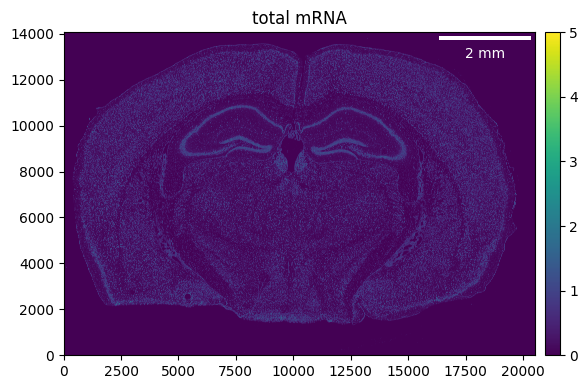

In [9]:
xenium.calculate_total_mRNA()

_ = xenium.plot_genecount(im_kwargs={"vmax": 5})

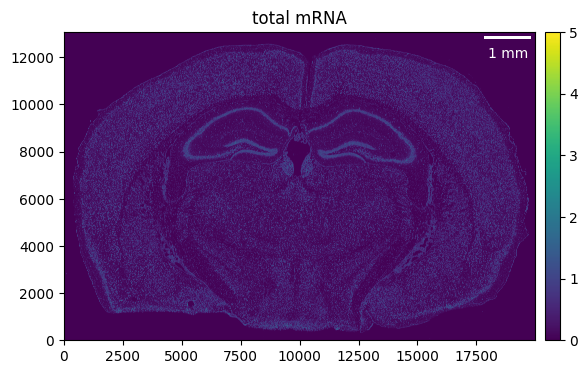

In [10]:
xenium.counts.crop(x=(None, 20_000), y=(1_000, None))

xenium.calculate_total_mRNA()

_ = xenium.plot_genecount(im_kwargs={"vmax": 5})

In [11]:
xenium.gaussian_kernel(8)

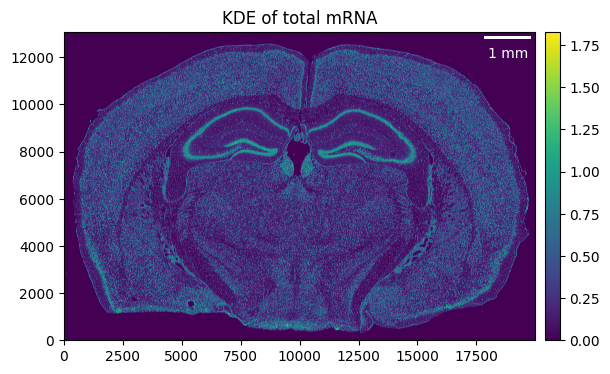

In [12]:
xenium.calculate_total_mRNA_KDE()

_ = xenium.plot_KDE()

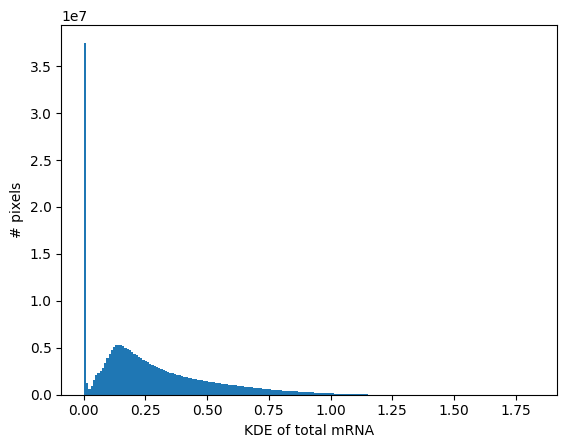

In [13]:
_ = xenium.plot_KDE_histogram(bins=200)

In [14]:
xenium.filter_background(0.05)

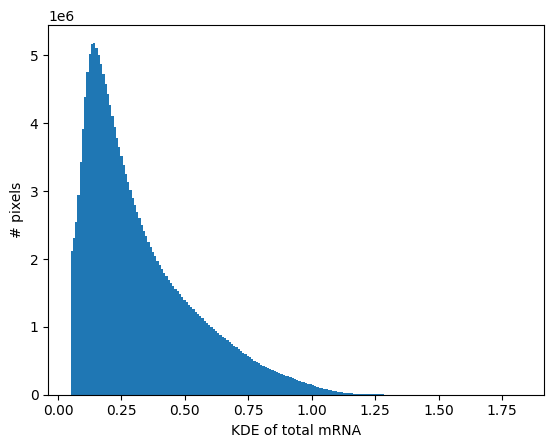

In [15]:
_ = xenium.plot_KDE_histogram(bins=200, remove_background=True)

# Celltype assignment

In [6]:
import json

with open(celltype_color_file, "r") as f:
    cmap = json.load(f)

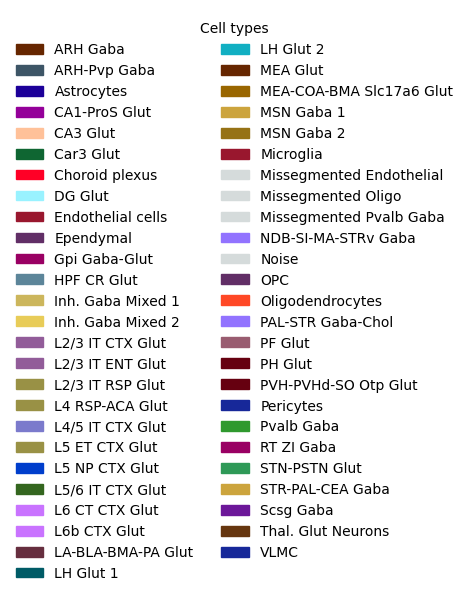

In [35]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

fig, ax = plt.subplots(figsize=(5, 6))

legend = [Patch(color=c, label=lbl) for lbl, c in cmap.items()]
_ = ax.legend(handles=legend, title="Cell types", frameon=False, ncols=2)
ax.set_axis_off()

fig.tight_layout()

In [36]:
fig.savefig(Path("figures") / "Xenium_segmentation_legend.pdf")

## celltyping

In [6]:
signatures = pd.read_table(signature_file_out, index_col=0).loc[
    :, lambda df: ~df.columns.str.startswith(("Missegmented", "Noise"))
]

In [8]:
xenium.assign_celltype(signatures)

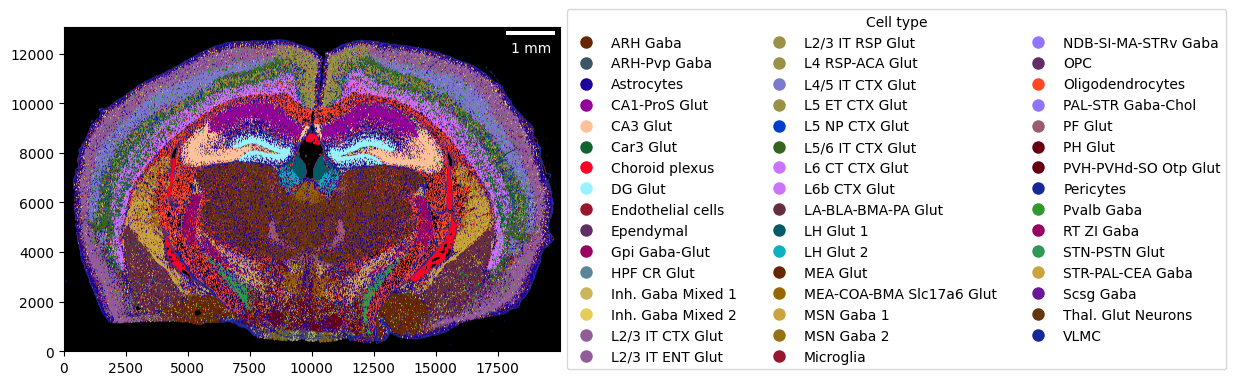

In [85]:
_ = xenium.plot_celltypemap(cmap=cmap)

#### Backroung and celltype map

In [8]:
kde_per_celltype = pd.DataFrame(
    {
        "kde": xenium.total_mRNA_KDE.flatten(),
        "celltype": pd.Categorical.from_codes(
            xenium.celltype_map.flatten(), categories=xenium.celltypes
        ),
    }
).dropna()

celltype_threshold = (
    kde_per_celltype.groupby("celltype", observed=True).quantile(0.8)["kde"] / 3
).to_dict()

min_t = 0.05

celltype_threshold = {
    ct: (t if t > min_t else min_t) for ct, t in celltype_threshold.items()
}

xenium.filter_background(celltype_threshold)

In [7]:
im = xenium.plot_celltypemap(cmap=cmap, background="white", return_img=True)

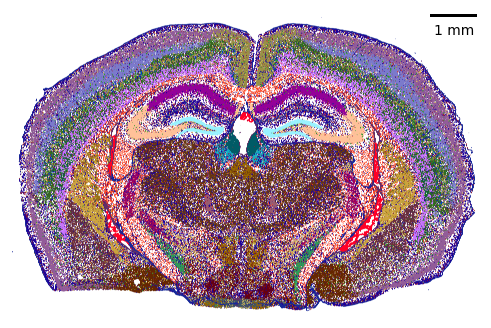

In [12]:
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

fig, ax = plt.subplots(figsize=(7.5, 4))
ax.imshow(im, origin="lower")
ax.add_artist(ScaleBar(500, **{"units": "nm", "box_alpha": 0}))
ax.set_axis_off()

In [14]:
fig.savefig("figures/Xenium_ctmap.pdf", dpi=600)

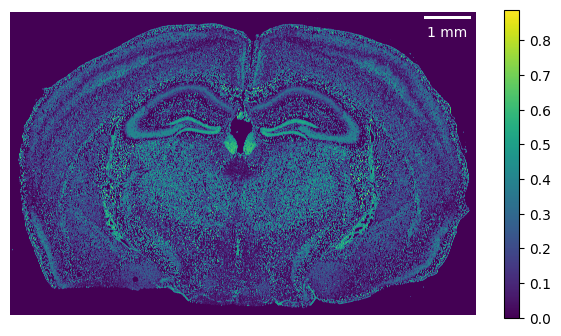

In [11]:
import matplotlib.pyplot as plt

im = xenium.assignment_score.copy()
im[xenium.background] = 0

fig, ax = plt.subplots(figsize=(7.5, 4))
im = ax.imshow(im.T, origin="lower", cmap=assignment_score_cmap)
ax.add_artist(ScaleBar(500, **{"units": "nm", "box_alpha": 0, "color": "w"}))
fig.colorbar(im, ax=ax)
ax.set_axis_off()

In [12]:
fig.savefig("figures/Xenium_assignment_score.pdf", dpi=600)

## "misassigned" regions

In [13]:
xenium_segmentation = xenium_segmentation[xenium_segmentation.obs["replicate"] == "1"]

x = xenium_segmentation.obs["x_centroid"].to_numpy()
y = xenium_segmentation.obs["y_centroid"].to_numpy()

xenium_segmentation.obsm["spatial"] = np.vstack([x, y]).T

/tmp/ipykernel_696805/3088973424.py:6: ImplicitModificationWarning: Setting element `.obsm['spatial']` of view, initializing view as actual.
  xenium_segmentation.obsm["spatial"] = np.vstack([x, y]).T


### RT ZI

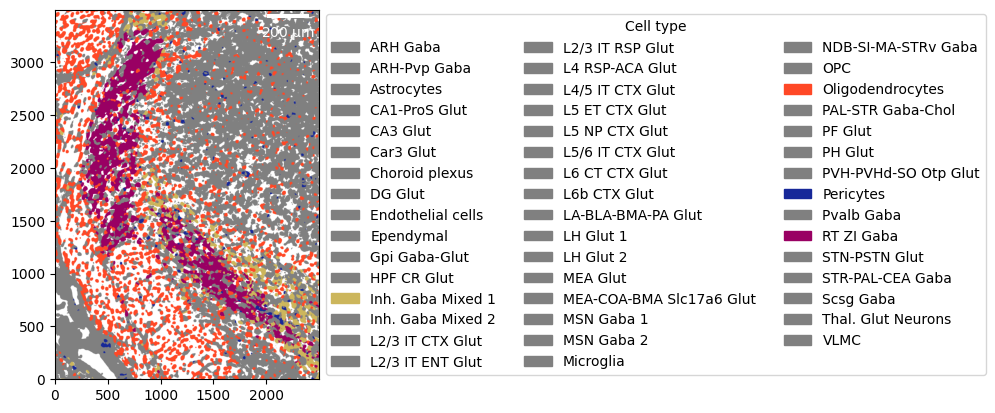

In [14]:
rtzi_coi = ["RT ZI Gaba", "Oligodendrocytes", "Inh. Gaba Mixed 1", "Pericytes"]

fig = xenium.plot_celltypemap(
    cmap={ct: cmap[ct] for ct in rtzi_coi},
    crop=((4500, 7000), (3000, 6500)),
    background="white",
)

In [15]:
rt_zi_ct = xenium.plot_celltypemap(
    cmap={ct: cmap[ct] for ct in rtzi_coi},
    crop=((4500, 7000), (3000, 6500)),
    background="white",
    return_img=True,
)

/dh-projects/ag-ishaque/analysis/muellni/envs/sainsc/lib/python3.10/site-packages/scanpy/plotting/_utils.py:471: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


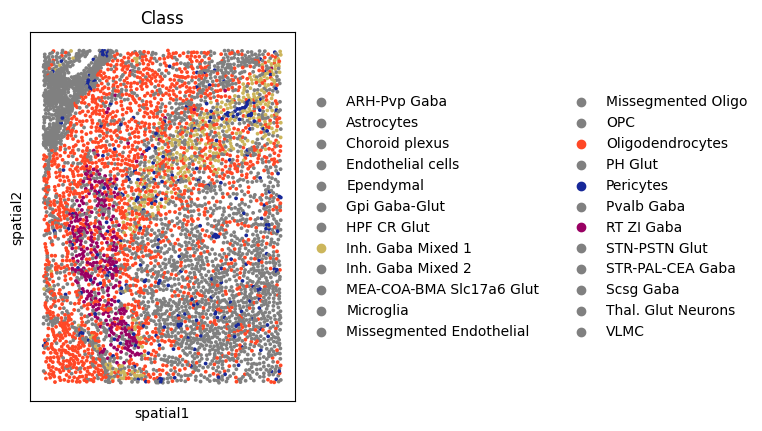

In [16]:
RT_ZI = xenium_segmentation[xenium_segmentation.obs["replicate"] == "1"]
RT_ZI = RT_ZI[
    (RT_ZI.obsm["spatial"][:, 0] >= 4500 / 2)
    & (RT_ZI.obsm["spatial"][:, 0] <= 7000 / 2)
    & (RT_ZI.obsm["spatial"][:, 1] >= (3000 + 1000) / 2)
    & (RT_ZI.obsm["spatial"][:, 1] <= (6500 + 1000) / 2)
]

sc.pl.spatial(
    RT_ZI,
    color="Class",
    spot_size=20,
    palette={ct: (cmap[ct] if ct in rtzi_coi else "grey") for ct in cmap.keys()},
)

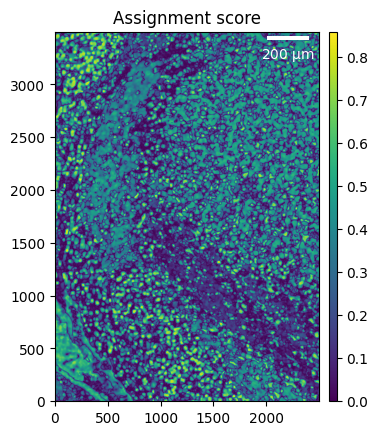

In [17]:
_ = xenium.plot_assignment_score(crop=((4500, 7000), (3000, 6500)))

In [18]:
rt_zi_as = xenium.assignment_score.copy()
rt_zi_as[xenium.background] = 0

rt_zi_as = rt_zi_as[4500:7000, 3000:6500]

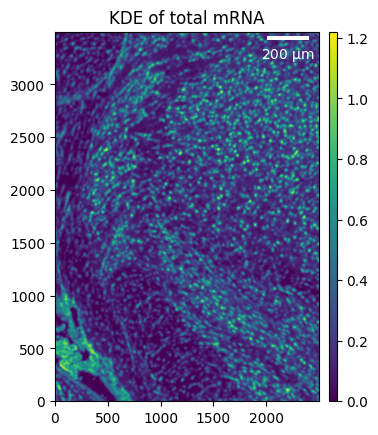

In [19]:
_ = xenium.plot_KDE(crop=((4500, 7000), (3000, 6500)))

In [20]:
rt_zi_kde = xenium.total_mRNA_KDE.copy()
rt_zi_kde[xenium.background] = 0

rt_zi_kde = rt_zi_kde[4500:7000, 3000:6500]

### PVT

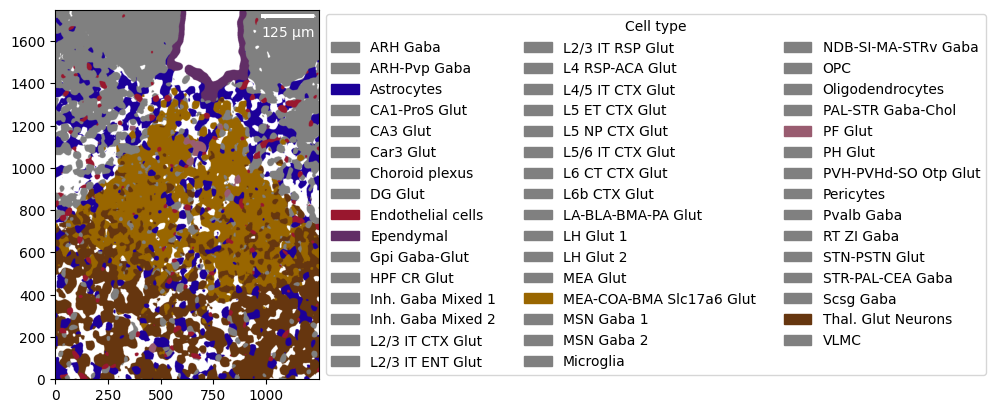

In [21]:
pvt_coi = [
    "Ependymal",
    "Thal. Glut Neurons",
    "MEA-COA-BMA Slc17a6 Glut",
    "PF Glut",
    "Endothelial cells",
    "Astrocytes",
]

fig = xenium.plot_celltypemap(
    cmap={ct: cmap[ct] for ct in pvt_coi},
    crop=((9_150, 10_400), (5_500, 7_250)),
    background="white",
)

In [22]:
pvt_ct = xenium.plot_celltypemap(
    cmap={ct: cmap[ct] for ct in pvt_coi},
    crop=((9_150, 10_400), (5_500, 7_250)),
    background="white",
    return_img=True,
)

/dh-projects/ag-ishaque/analysis/muellni/envs/sainsc/lib/python3.10/site-packages/scanpy/plotting/_utils.py:471: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


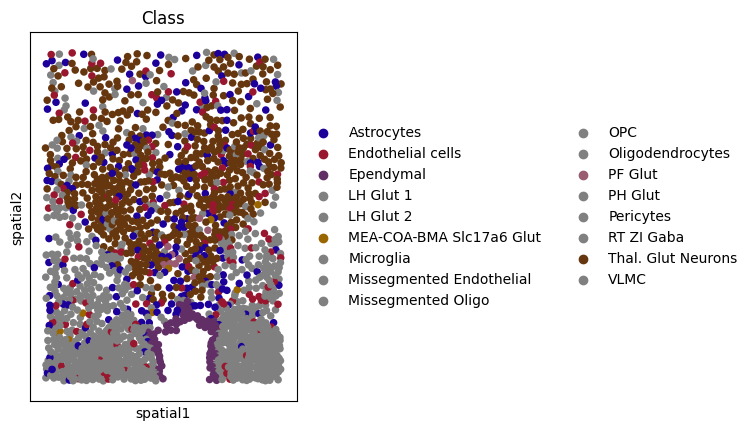

In [23]:
PVT = xenium_segmentation[xenium_segmentation.obs["replicate"] == "1"]
PVT = PVT[
    (PVT.obsm["spatial"][:, 0] >= 9_150 / 2)
    & (PVT.obsm["spatial"][:, 0] <= 10_400 / 2)
    & (PVT.obsm["spatial"][:, 1] >= (5_500 + 1000) / 2)
    & (PVT.obsm["spatial"][:, 1] <= (7_250 + 1000) / 2)
]

sc.pl.spatial(
    PVT,
    color="Class",
    spot_size=20,
    palette={ct: (cmap[ct] if ct in pvt_coi else "grey") for ct in cmap.keys()},
)

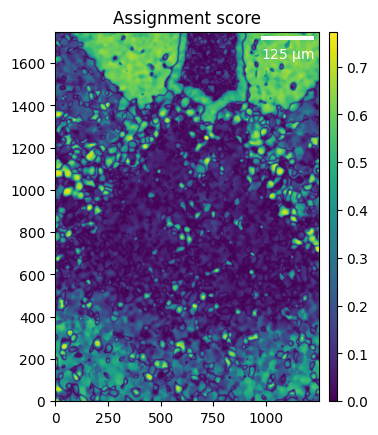

In [24]:
fig = xenium.plot_assignment_score(crop=((9_150, 10_400), (5_500, 7_250)))

In [25]:
pvt_as = xenium.assignment_score.copy()
pvt_as[xenium.background] = 0

pvt_as = pvt_as[9_150:10_400, 5_500:7_250]

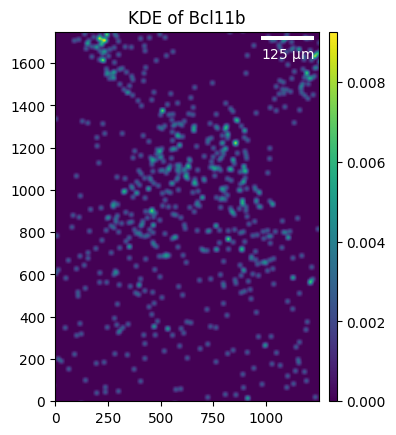

In [26]:
fig = xenium.plot_KDE(gene="Bcl11b", crop=((9_150, 10_400), (5_500, 7_250)))

In [27]:
pvt_kde_bcl11b = xenium.kde(gene="Bcl11b").toarray()
pvt_kde_bcl11b[xenium.background] = 0

pvt_kde_bcl11b = pvt_kde_bcl11b[9_150:10_400, 5_500:7_250]

#### Yao (2023)

In [18]:
from sklearn.metrics.pairwise import cosine_similarity

mea_coa_bma_sig = pd.read_table(signature_file_out, index_col=0)[
    "MEA-COA-BMA Slc17a6 Glut"
]
thal_neurons_sig = pd.read_table(signature_file_out, index_col=0)["Thal. Glut Neurons"]

pvt_sig = pd.read_table(signature_file_abc_atlas, index_col=0).loc[
    mea_coa_bma_sig.index, "149 PVT-PT Ntrk1 Glut"
]

sigs_compare = mea_coa_bma_sig.to_frame().join(thal_neurons_sig).join(pvt_sig)

In [25]:
sigs_compare.columns.to_list()

['MEA-COA-BMA Slc17a6 Glut', 'Thal. Glut Neurons', '149 PVT-PT Ntrk1 Glut']

In [22]:
cosine_similarity(sigs_compare.T)

array([[1.        , 0.79236647, 0.61343477],
       [0.79236647, 1.        , 0.66992077],
       [0.61343477, 0.66992077, 1.        ]])

In [43]:
signatures = pd.read_table(signature_file_abc_atlas, index_col=0).loc[
    lambda df: df.index.isin(xenium.genes)
]

signatures.shape

(248, 34)

In [44]:
xenium.assign_celltype(signatures)

In [29]:
kde_per_celltype = pd.DataFrame(
    {
        "kde": xenium.total_mRNA_KDE.flatten(),
        "celltype": pd.Categorical.from_codes(
            xenium.celltype_map.flatten(), categories=xenium.celltypes
        ),
    }
).dropna()

celltype_threshold = (
    kde_per_celltype.groupby("celltype", observed=True).quantile(0.8)["kde"] / 3
).to_dict()

min_t = 0.05

celltype_threshold = {
    ct: (t if t > min_t else min_t) for ct, t in celltype_threshold.items()
}

xenium.filter_background(celltype_threshold)

In [30]:
import colorcet as cc
import seaborn as sns

cmap_yao = dict(
    zip(
        xenium.celltypes,
        sns.color_palette(cc.glasbey, n_colors=len(xenium.celltypes)),
    )
)

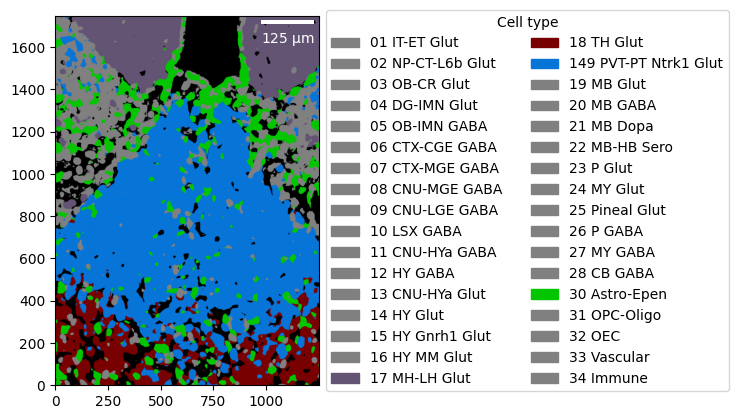

In [31]:
_ = xenium.plot_celltypemap(
    cmap={
        ct: col
        for ct, col in cmap_yao.items()
        if ct
        in ["149 PVT-PT Ntrk1 Glut", "17 MH-LH Glut", "18 TH Glut", "30 Astro-Epen"]
    },
    crop=((9_150, 10_400), (5_500, 7_250)),
)

In [32]:
pvt_ct_yao = xenium.plot_celltypemap(
    cmap={
        ct: col
        for ct, col in cmap_yao.items()
        if ct
        in ["149 PVT-PT Ntrk1 Glut", "17 MH-LH Glut", "18 TH Glut", "30 Astro-Epen"]
    },
    crop=((9_150, 10_400), (5_500, 7_250)),
    return_img=True,
    background="white",
)

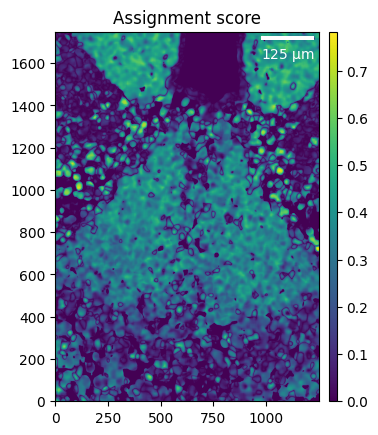

In [33]:
_ = xenium.plot_assignment_score(
    remove_background=True, crop=((9_150, 10_400), (5_500, 7_250))
)

In [34]:
pvt_as_yao = xenium.assignment_score.copy()
pvt_as_yao[xenium.background] = 0

pvt_as_yao = pvt_as_yao[9_150:10_400, 5_500:7_250]

## Figure

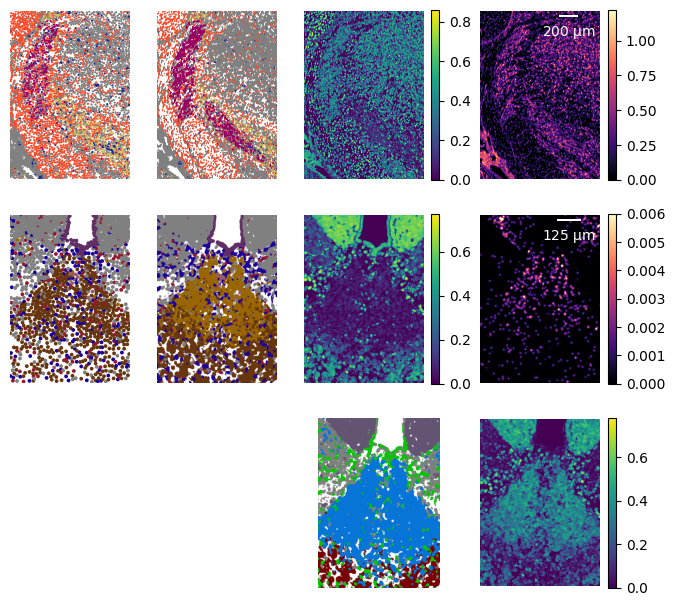

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_scalebar.scalebar import ScaleBar

fig, axs = plt.subplots(3, 4, figsize=(8, 7.5), width_ratios=[1, 1, 1.25, 1.25])

sns.scatterplot(
    x=RT_ZI.obsm["spatial"][:, 0],
    y=RT_ZI.obsm["spatial"][:, 1],
    hue=RT_ZI.obs["Class"],
    legend=False,
    ax=axs[0, 0],
    palette={ct: (cmap[ct] if ct in rtzi_coi else "grey") for ct in cmap.keys()},
    s=10,
    linewidth=0,
    marker=".",
)
axs[0, 0].set(aspect=1, xlim=(4500 / 2, 7000 / 2), ylim=(4000 / 2, 7500 / 2))

axs[0, 1].imshow(rt_zi_ct, origin="lower")

im = axs[0, 2].imshow(rt_zi_as.T, origin="lower", cmap=assignment_score_cmap)
fig.colorbar(im, ax=axs[0, 2])

im = axs[0, 3].imshow(rt_zi_kde.T, origin="lower", cmap=kde_cmap)
fig.colorbar(im, ax=axs[0, 3])
axs[0, 3].add_artist(ScaleBar(500, **{"units": "nm", "box_alpha": 0, "color": "w"}))

sns.scatterplot(
    x=PVT.obsm["spatial"][:, 0],
    y=PVT.obsm["spatial"][:, 1],
    hue=PVT.obs["Class"],
    legend=False,
    ax=axs[1, 0],
    palette={ct: (cmap[ct] if ct in pvt_coi else "grey") for ct in cmap.keys()},
    s=30,
    linewidth=0,
    marker=".",
)

axs[1, 0].set(aspect=1, xlim=(9_150 / 2, 10_400 / 2), ylim=(6_500 / 2, 8_250 / 2))

axs[1, 1].imshow(pvt_ct, origin="lower")

im = axs[1, 2].imshow(pvt_as.T, origin="lower", cmap=assignment_score_cmap)
fig.colorbar(im, ax=axs[1, 2])

im = axs[1, 3].imshow(pvt_kde_bcl11b.T, origin="lower", vmax=0.006, cmap=kde_cmap)
fig.colorbar(im, ax=axs[1, 3])
axs[1, 3].add_artist(ScaleBar(500, **{"units": "nm", "box_alpha": 0, "color": "w"}))


axs[2, 2].imshow(pvt_ct_yao, origin="lower")

im = axs[2, 3].imshow(pvt_as_yao.T, origin="lower", cmap=assignment_score_cmap)
fig.colorbar(im, ax=axs[2, 3])


for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i, j].set_axis_off()

In [36]:
fig.savefig("figures/Fig_Xenium_subsections.pdf", dpi=600)

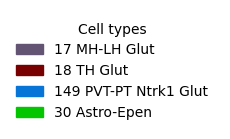

In [90]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

ct_of_interest = [
    "149 PVT-PT Ntrk1 Glut",
    "17 MH-LH Glut",
    "18 TH Glut",
    "30 Astro-Epen",
]

fig, ax = plt.subplots(figsize=(2.5, 1.5))

legend = [
    Patch(color=c, label=lbl) for lbl, c in cmap_yao.items() if lbl in ct_of_interest
]
_ = ax.legend(handles=legend, title="Cell types", frameon=False)
ax.set_axis_off()

fig.tight_layout()

In [91]:
fig.savefig("figures/Fig_Xenium_yao_legend.pdf", dpi=600)